inspo: https://github.com/nikhitrivedi1/DQN

In [3]:
import time
from collections import (
    deque,
    namedtuple,
)  # deque -> memory buffer, namedtuple -> store experience tuples

import gym
import pandas
import numpy as np
import tensorflow as tf
import utilities
import PIL.Image
import seaborn as sns
import matplotlib.pyplot as plt

from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

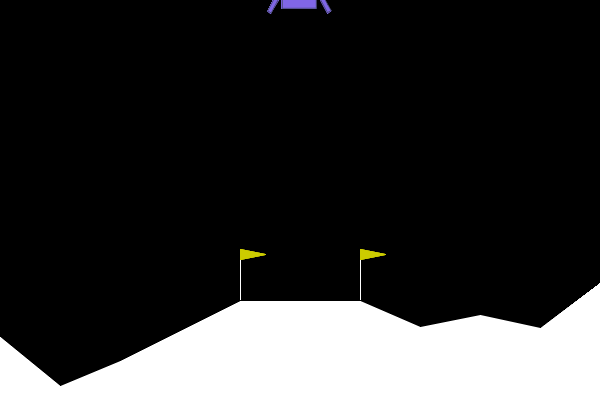

In [ ]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")
env.reset()
PIL.Image.fromarray(env.render())

In [ ]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print("State Shape:", state_size)
print("Number of actions:", num_actions)

State Shape: (8,)
Number of actions: 4


In [ ]:
MEMORY_SIZE = 10000  # size of memory buffer
GAMMA = 0.995  # discount factor
ALPHA = 1e-3  # learning rate
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

coordinate plane of the environment (x,y), the tilt of the lunar craft ($\theta$) the velocities of the lunar module decending (x',y', $\theta'$), and whether or not the lander has the left (L) or right (R) foot touching the surface.

This environment state will represent the input layer of the neural network noted by 1x8 state vector:
[x, y, $\theta$, x', y', $\theta'$, L, R]

In [ ]:
q_network = Sequential(
    [
        Input(shape=state_size),
        Dense(units=64, activation="relu"),
        Dense(units=64, activation="relu"),
        Dense(units=num_actions, activation="linear"),
    ]
)

q_target_network = Sequential(
    [
        Input(shape=state_size),
        Dense(units=64, activation="relu"),
        Dense(units=64, activation="relu"),
        Dense(units=num_actions, activation="linear"),
    ]
)

optimizer = Adam(learning_rate=ALPHA)

print(type(q_network))

In [ ]:
Experience = namedtuple(
    "Experience", field_names=["state", "action", "reward", "next_state", "done"]
)

In [ ]:
def compute_loss(experiences, gamma, q_target, q_network):
    # experiences - (named tuple - 5 fields) -  ['current_state', 'current_action', 'reward', 'next_state', 'terminal']
    # gamma - (float) defined in hyperparameter
    # q_target - ('keras.src.models.sequential.Sequential)
    # q_network - ('keras.src.models.sequential.Sequential)

    # unpack experiences
    state, action, reward, next_state, done = experiences

    # Extract max Q(s,a) from Q_target
    q_max_sa = tf.reduce_max(q_target(next_state), axis=1)

    # Calculate y_Target using variables
    y_target = reward + (1 - done) * (gamma * q_max_sa)

    # Extract Q_Values and reshape to shape of y_target
    q_values = q_network(state)
    q_values = tf.gather_nd(
        q_values,
        tf.stack([tf.range(q_values.shape[0]), tf.cast(action, tf.int32)], axis=1),
    )

    # Calculate MSE between q_target and q_network
    loss = MSE(y_target, q_values)

    return loss

tf.function - decorator is used to convert a python function into a TensorFlow graph - allowing for the function to be executed much more efficiently

tf.GradientTape() as tape
    - a context manager that records operations for automatic differentiation - by recording the operations executed within the context, it allows you to compute gradients with respect to the recorded operations 

tape.gradient('target', 'sources', 'output_gradients')
    - 'target' - tensor to be differentied
    - 'sources' - the list or structure of tensors with respect to which the gradient is computed
    - computes the gradient of a target tensor (often a loss) with respect to some source tensors

optimizer.apply_gradients(zip('grads_and_vars'))
    - applies the computed gradients to the variable to minimize the loss
    - 'grads_and_vars' - a list of (gradient, variable) pairs

In [ ]:
@tf.function
def agent_learn(experiences, gamma):
    # use the training set (experiences) to define Qnew and use soft update to update the current weights and biases of Q
    with tf.GradientTape() as tape:
        loss = compute_loss(
            experiences,
            gamma,
            q_target_network,
            q_network,
        )

    gradients = tape.gradient(loss, q_network.trainable_variables)

    # update weights of the network using Adam's optimizer
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of the target q_network -> using soft update
    utilities.update_target_network(q_network, q_target_network)
    print(q_network)

In [ ]:
memory_buffer = deque(maxlen=MEMORY_SIZE)

In [ ]:
q_target_network.set_weights(q_network.get_weights())

In [ ]:
def execute_learning(epsilon, num_episodes, num_p_av, max_num_timesteps):

    # Execute Learning Algorithm
    total_point_history = []
    total_action_history = []
    episodes_to_comp = 0
    # target_num_episodes = 500
    start = time.time()

    for i in range(num_episodes):
        # recieve initial observation state S1 from environment
        state, _ = env.reset()
        total_points = 0
        for t in range(max_num_timesteps):
            # choose action At using e-greedy policy
            # use the current state as an input to determine what action
            # State => (8,1) matrix input
            state_qn = np.expand_dims(state, axis=0)
            q_values = q_network(state_qn)
            # take action in environment, receive reward R(t) and next state St+1
            action = utilities.get_action(q_values, epsilon)
            next_state, reward, done, _, _ = env.step(action)

            # Store Tuple into the memory buffer
            memory_buffer.append(Experience(state, action, reward, next_state, done))

            # Update Check: t steps > NUM_STEPS_FOR_UPDATE
            update = utilities.check_update_conditions(
                t, NUM_STEPS_FOR_UPDATE, memory_buffer
            )

            if update:
                experiences = utilities.get_experiences(memory_buffer)
                agent_learn(experiences, GAMMA)

            state = next_state.copy()
            total_points += reward

            if done:
                break

        total_point_history.append(total_points)
        av_latest_points = np.mean(total_point_history[-num_p_av:])
        # calculate new eps for greedy alg
        norm_episodes = i / num_episodes
        epsilon = utilities.get_new_eps(epsilon, norm_episodes)

        print(
            f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}",
            end="",
        )

        if (i + 1) % num_p_av == 0:
            print(
                f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}"
            )

        if av_latest_points >= 200.0:
            print(f"\n\nEnvironment solved in {i+1} episodes!")
            q_network.save("lunar_lander_model.h5")
            break
        episodes_to_comp += 1

    tot_time = time.time() - start

    print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

    return (total_point_history, i)

In [ ]:
epsilon = 1.0
num_episodes = 2000
num_p_av = 100  # number of total points to use for averaging
max_num_timesteps = 1000

In [ ]:
# Run the learning protocol for 100 times for each configuration to confirm the validity of model imporvement
df = pandas.DataFrame(columns=["EPOCH", "Total Point Average", "Epsilon"])
k = 1

total_point, episodes = execute_learning(
    epsilon, num_episodes, num_p_av, max_num_timesteps
)
# concatinate dataframe to include this information
epoch_arr = np.ones(len(total_point), dtype=int) * k
eps_arr = utilities.plot_epsilon()
# print(len(total_point), len(eps_arr), len(range(num_episodes-1)))
temp_dict = {"EPOCH": epoch_arr, "Total Point Average": total_point, "Epsilon": eps_arr}
temp_df = pandas.DataFrame.from_dict(temp_dict)
df = pandas.concat([df, temp_df], ignore_index=True)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


<Sequential name=sequential, built=True>
<Sequential name=sequential, built=True>
Episode 100 | Total point average of the last 100 episodes: -149.37
Episode 200 | Total point average of the last 100 episodes: -70.761
Episode 300 | Total point average of the last 100 episodes: -20.03
Episode 400 | Total point average of the last 100 episodes: 81.367
Episode 500 | Total point average of the last 100 episodes: 119.00
Episode 593 | Total point average of the last 100 episodes: 197.73

Episode 594 | Total point average of the last 100 episodes: 200.57

Environment solved in 594 episodes!

Total Runtime: 599.09 s (9.98 min)


/var/folders/__/gfdqjrkx7vnchgntyh02zn480000gn/T/ipykernel_39166/3128517313.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pandas.concat([df, temp_df], ignore_index=True)


[Text(0.5, 0, 'Update Number'), Text(0, 0.5, 'Epsilon (e)')]

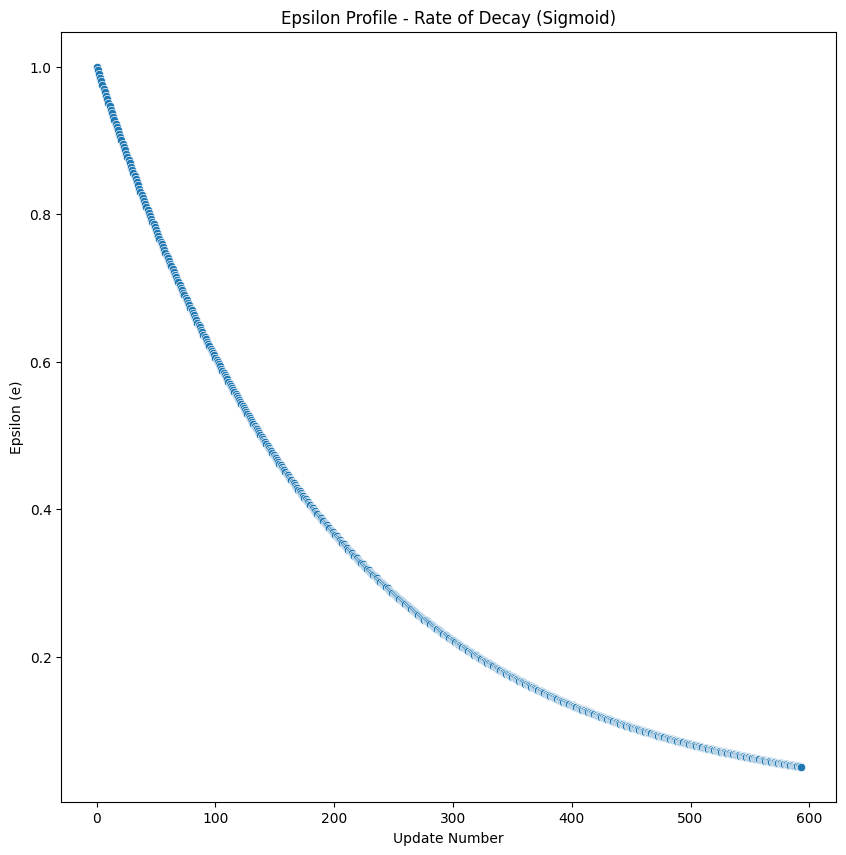

In [ ]:
eps_arr = utilities.plot_epsilon()
fig, ax = plt.subplots(figsize=(10, 10))
# print(eps_arr)
sns.scatterplot(x=range(len(eps_arr)), y=eps_arr, ax=ax)
plt.title("Epsilon Profile - Rate of Decay (Sigmoid)")
ax.set(xlabel="Update Number", ylabel="Epsilon (e)")

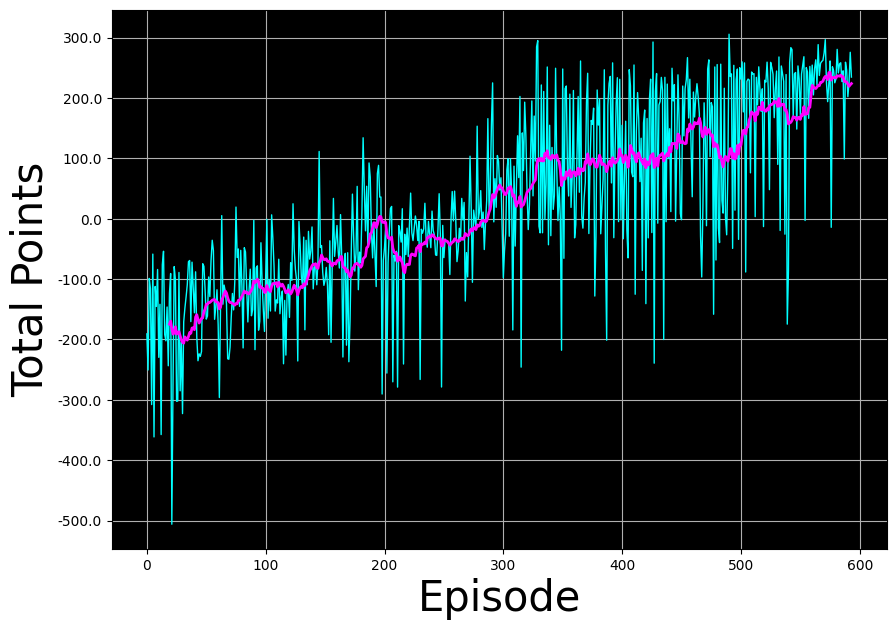

In [ ]:
FILENAME = "EPS_LIN_10_sample_data.csv"
utilities.plot_history(df["Total Point Average"])

In [4]:
# Uruchomienie środowiska z renderowaniem
env = gym.make("LunarLander-v2", render_mode="human")

# Załadowanie najlepszego modelu i przeprowadzenie symulacji
best_model = tf.keras.models.load_model("lunar_lander_model.h5")


def simulate_best_model(env, model, num_episodes=1):
    for i in range(num_episodes):
        state, _ = env.reset()
        total_rewards = 0
        done = False
        while not done:
            env.render()
            state_qn = np.expand_dims(state, axis=0)
            q_values = model(state_qn)
            action = np.argmax(q_values)
            next_state, reward, done, _, _ = env.step(action)
            state = next_state
            total_rewards += reward
        print(f"Episode {i+1}: Total Reward: {total_rewards}")


# Przeprowadzenie symulacji z najlepszym modelem
simulate_best_model(env, best_model)
env.close()

2024-06-12 21:54:51.292 Python[59114:14418399] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1: Total Reward: 227.80653107456146


: 